In [5]:
import numpy as np
import matplotlib.pyplot as plt 
import os
import json
import tensorflow as tf
from PIL import Image
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from sklearn.metrics import pairwise_distances
from scipy.stats import entropy
from scipy.linalg import sqrtm
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import randint
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3
from skimage.transform import resize

In [6]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
# Specify CUDA Device
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Set the GPU device index to use
    
# Configure TensorFlow GPU Options
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            print("Using GPU")
    except RuntimeError as e:
        print(e)
else:
    print("GPU not found, using CPU") 

Num GPUs Available:  0
[]
GPU not found, using CPU


Loading the path and the dataset


Path loaded successfully as =  C:\CelebA


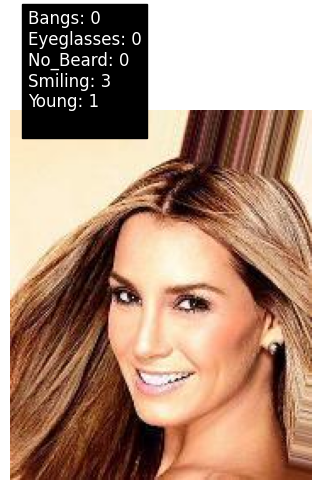

In [7]:
# Set the paths to the dataset folder
dataset_folder = "C:\CelebA"
images_folder = os.path.join(dataset_folder, "Images")

annotations_file = os.path.join(dataset_folder, "combined_annotation.txt")
train_file = os.path.join(dataset_folder, "train_attr_list.txt")
test_file = os.path.join(dataset_folder, "test.txt")

print("Path loaded successfully as = ", dataset_folder)


# Define attribute names
attribute_names = ['Bangs', 'Eyeglasses', 'No_Beard', 'Smiling', 'Young']

# Load the annotated attributes
annotations = {}
with open(annotations_file, 'r') as file:
    lines = file.readlines()
    attribute_indices = {name: idx for idx, name in enumerate(attribute_names)}
    for line in lines[1:]:
        line = line.strip().split()
        image_filename = line[0]
        attribute_vector = np.array([int(val) for val in line[1:]], dtype=np.float32)
        annotations[image_filename] = attribute_vector
        
# Load the training subset from the file
with open(train_file, 'r') as file:
    train_data = file.readlines()
    train_image_filenames = [line.split()[0] for line in train_data]
    
# Load the testing subset from the file
with open(test_file, 'r') as file:
    test_data = file.readlines()
    test_image_filenames = [line.split()[0] for line in test_data]
      
       
# Choose an image to plot
image_filename = "000001.jpg"

# Load and plot the image
image_path = os.path.join(images_folder, image_filename)
image = Image.open(image_path)
plt.imshow(image)
plt.axis('off')

# Retrieve the attribute values for the image
attributes = annotations[image_filename]

# Create the attribute label
attribute_label = ''
for i, value in enumerate(attributes):
    if value  >=0:
        attribute_label += f'{attribute_names[i]}: {int(value)}\n'

# Add the attribute label to the plot
plt.text(10, 10, attribute_label, fontsize=12, color='white', backgroundcolor='black')

# Show the plot
plt.show() 

Initialising the GAN architecture

In [8]:
# Define GAN model architecture
latent_dim = 100  # Dimensionality of the latent space

# Adjust this based on the number of attributes (5 in our case)
num_attributes = 5  

generator = tf.keras.Sequential([
    tf.keras.layers.Dense(4 * 4 * 512, input_shape=(latent_dim + num_attributes,)),
    tf.keras.layers.Reshape((4, 4, 512)),
    tf.keras.layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same'),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same', activation='sigmoid')  # Output with 3 channels (RGB)
])


discriminator = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=(64, 64, 3)),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

generator.summary()
discriminator.summary()

# Combine generator and discriminator into a cGAN model
gan = tf.keras.Sequential([generator, discriminator])

# Define loss function and optimizers
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8192)              868352    
                                                                 
 reshape (Reshape)           (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 8, 8, 256)         2097408   
 anspose)                                                        
                                                                 
 batch_normalization (Batch  (None, 8, 8, 256)         1024      
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 16, 16, 128)       5

PRE-PROCESSING THE IMAGES FOR TRAINING

In [12]:
# Preprocess and load the images
def preprocess_image(image_path):
    image = Image.open(image_path)
    image = image.resize((64, 64))
    image = np.array(image) / 255.0
    return image

def load_images(image_filenames):
    images = []
    for image_filename in image_filenames:
        image_path = os.path.join(images_folder, image_filename)
        image = preprocess_image(image_path)
        images.append(image)
    return np.array(images)

In [ ]:
# Load the images from the training subset
images = load_images(train_image_filenames)
attributes = np.array([annotations[filename] for filename in train_image_filenames])
attributes = attributes.astype(int)

# Combine images, attributes for training
training_data = (images, attributes)

# Display a single preprocessed image
plt.imshow(images[0])
plt.axis('off')
plt.show()

Training the GAN model


In [ ]:
# Compile the generator model
generator.compile(optimizer=generator_optimizer, loss=loss_fn)

# Training loop
batch_size = 64
epochs = 100  

for epoch in range(epochs):
    for i in range(0, len(images), batch_size):
        image_batch = images[i:i + batch_size]
        attribute_batch = attributes[i:i + batch_size]

        # Generate random latent vectors
        latent_vectors = np.random.randn(len(image_batch), latent_dim)

        # Concatenate latent vectors, attribute_batch
        input_data = np.concatenate([latent_vectors, attribute_batch], axis=1)

        # Train the discriminator
        with tf.GradientTape() as disc_tape:
            generated_images = generator(input_data, training=True)
            real_output = discriminator(image_batch, training=True)
            fake_output = discriminator(generated_images, training=True)
            disc_loss = loss_fn(tf.ones_like(real_output), real_output) + loss_fn(tf.zeros_like(fake_output), fake_output)
        gradients_disc = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(gradients_disc, discriminator.trainable_variables))

        # Train the generator
        with tf.GradientTape() as gen_tape:
            generated_images = generator(input_data, training=True)
            fake_output = discriminator(generated_images, training=True)
            gen_loss = loss_fn(tf.ones_like(fake_output), fake_output)
        gradients_gen = gen_tape.gradient(gen_loss, generator.trainable_variables)
        generator_optimizer.apply_gradients(zip(gradients_gen, generator.trainable_variables))

        # Print losses for monitoring
        print(f"Epoch: {epoch + 1}/{epochs}, Batch: {i}/{len(images)}, Generator Loss: {gen_loss.numpy()}, Discriminator Loss: {disc_loss.numpy()}")
        
        
        #Visualize generated images during training
        if i % (batch_size * 10) == 0:
            # Generate a batch of images using the current generator model
            generated_images = generator.predict(input_data)

            # Create a grid of generated images and display them
            nrows = 4  
            ncols = 8
            fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 2, nrows * 2))
            for ax, img in zip(axes.flat, generated_images):
                ax.imshow(img)
                ax.axis('off')
            plt.suptitle(f"Epoch {epoch + 1}, Batch {i}", fontsize=16)
            plt.show()


# Save the trained generator model
generator.save('generator_model.h5')

Loading evaluation models

In [15]:
# Load the pre-trained InceptionV3 model
inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))

generator = tf.keras.models.load_model('generator_model.h5')

num_generated_images = 100  # Adjust the number of generated images
latent_dim = 100  # Adjust the latent dimension
num_iterations = 100  # Number of iterations to generate images and calculate scores

Evaluating using IS


1/1 [==============================] - 1s 564ms/step
Iteration 1 - Inception Score: 1.0004
1/1 [==============================] - 1s 533ms/step
Iteration 2 - Inception Score: 1.0005
1/1 [==============================] - 1s 542ms/step
Iteration 3 - Inception Score: 1.0004
1/1 [==============================] - 0s 467ms/step
Iteration 4 - Inception Score: 1.0004
1/1 [==============================] - 0s 489ms/step
Iteration 5 - Inception Score: 1.0003
1/1 [==============================] - 0s 486ms/step
Iteration 6 - Inception Score: 1.0003
1/1 [==============================] - 1s 505ms/step
Iteration 7 - Inception Score: 1.0004
1/1 [==============================] - 1s 517ms/step
Iteration 8 - Inception Score: 1.0005
1/1 [==============================] - 1s 505ms/step
Iteration 9 - Inception Score: 1.0004
1/1 [==============================] - 1s 527ms/step
Iteration 10 - Inception Score: 1.0005
1/1 [==============================] - 1s 559ms/step
Iteration 11 - Inception Score: 1.00

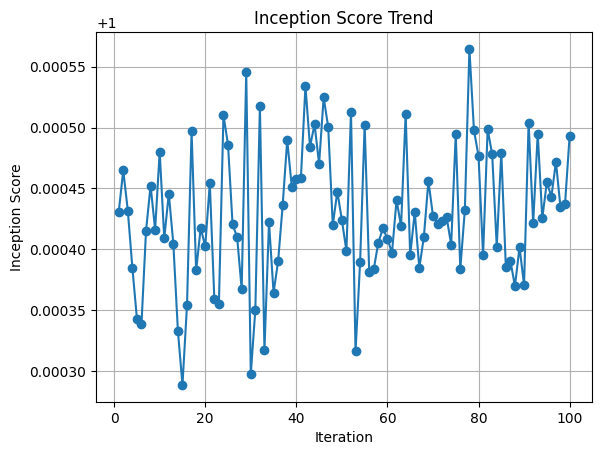

In [17]:
# Evaluate the generator using the Inception Score
def calculate_inception_score(images, num_splits=10):
    # Split images into chunks for stability
    image_chunks = np.array_split(images, num_splits)
    scores = []
    for chunk in image_chunks:
        # Resize images to 299x299x3 for InceptionV3
        resized_images = tf.image.resize(chunk, (299, 299))
        
        # Preprocess images for InceptionV3
        processed_images = preprocess_input(resized_images)
        
        # Get the predictions from InceptionV3
        predictions = inception_model.predict(processed_images)
        
        # Calculate the class probabilities
        p_yx = np.exp(predictions) / np.sum(np.exp(predictions), axis=1, keepdims=True)
        
        # Calculate the marginal probabilities
        p_y = np.mean(p_yx, axis=0, keepdims=True)
        
        # Calculate the Inception Score for this chunk
        kl_divergence = np.sum(p_yx * (np.log(p_yx) - np.log(p_y)), axis=1)
        kl_divergence_mean = np.mean(kl_divergence)
        score = np.exp(kl_divergence_mean)
        scores.append(score)
    
    # Calculate the mean Inception Score across all chunks
    inception_score = np.mean(scores)
    return inception_score

inception_scores = []  # Store the Inception Scores for each iteration
for _ in range(num_iterations):
    generated_images = []
    for _ in range(num_generated_images):
        noise_vector = np.random.randn(1, latent_dim)
        attribute_intensities = np.random.randint(0, 5, size=(1, num_attributes))
        final_input = np.concatenate([noise_vector, attribute_intensities], axis=1)
        generated_image = generator.predict(final_input)
        generated_images.append(generated_image[0])

    generated_images = np.array(generated_images)
    inception_score = calculate_inception_score(generated_images)
    inception_scores.append(inception_score)

    print(f"Iteration {len(inception_scores)} - Inception Score: {inception_score:.4f}")

# Plotting the Inception Scores
plt.figure()
plt.plot(range(1, num_iterations + 1), inception_scores, marker='o')
plt.xlabel("Iteration")
plt.ylabel("Inception Score")
plt.title("Inception Score Trend")
plt.grid()
plt.show()


Evaluating using FID


In [19]:
# I'd like to acknowledge Jason Brownlee for providing this valuable code snippet to evaluate the FID score
# https://machinelearningmastery.com/how-to-implement-the-frechet-inception-distance-fid-from-scratch/

# scale an array of images to a new size
def scale_images(images, new_shape):
    images_list = list()
    for image in images:
        # resize with nearest neighbor interpolation
        new_image = resize(image, new_shape, 0)
        # store
        images_list.append(new_image)
    return asarray(images_list)

# Function to calculate FID score
def calculate_fid(real_images, gen_images):
    #calculate the activation features
    real_features = inception_model.predict(real_images)
    gen_features = inception_model.predict(gen_images)
   
    # calculate mean and covariance statistics
    mu1, sigma1 = real_features.mean(axis=0), cov(real_features, rowvar=False)
    mu2, sigma2 = gen_features.mean(axis=0), cov(gen_features, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)
    #calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    #check and correct imaginary numbers from sqrt
    if iscomplexobj(covmean):
        covmean = covmean.real 
    fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid
 
# Generate random images    
gen_images=[]
fid_scores=[]
for _ in range(num_generated_images):
    noise_vector = np.random.randn(1, latent_dim)
    attribute_intensities = np.random.randint(0, 5, size=(1, num_attributes))
    final_input = np.concatenate([noise_vector, attribute_intensities], axis=1)
    generated_image = generator.predict(final_input)
    gen_images.append(generated_image[0])
    
#Load the real images and generated images      
real_images = load_images(test_image_filenames)
gen_images = np.array(gen_images)

print('Prepared', real_images.shape, gen_images.shape)

# convert int to float values
real_images = real_images.astype('float32')
gen_images = gen_images.astype('float32')

real_images = scale_images(real_images, (299,299,3))
gen_images = scale_images(generated_images, (299,299,3))

print('Scaled', real_images.shape, gen_images.shape)

# Preprocess images and get features

real_images = preprocess_input(real_images)
gen_images = preprocess_input(gen_images)
    
#Calculate FID    
fid = calculate_fid(real_images, gen_images)
print('FID (different): %.3f' % fid)
fid_scores.append(fid)

1/1 [==============================] - 0s 27ms/step
Prepared (100, 64, 64, 3) (100, 64, 64, 3)
Scaled (100, 299, 299, 3) (100, 299, 299, 3)
4/4 [==============================] - 5s 1s/step
FID (different): 35304197551969453374202019929728677969351446386337040214481670890204166707261500707827182564376884414162738679314907136.000
